# Agent with Basic Functionality and Configuration

## References 

https://www.youtube.com/watch?v=hvAPnpSfSGo


## States

In [1]:
from typing import Annotated

from langchain_core.runnables import RunnableConfig
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field


class ConductResearch(BaseModel):
    """Call this tool to conduct research on a specific topic."""

    research_topic: str = Field(
        description="Project idea with detailed description (as much as information possible) by User",
    )


class ResearchComplete(BaseModel):
    """Call this tool to indicate that the research is complete."""


class Summary(BaseModel):
    Summary: str
    key_excerpts: str


class ClarifyWithUser(BaseModel):
    """Call this tool to ask a clarification questions/infomartion to the user."""

    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarification question.",
    )
    question: str = Field(
        description="The question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )


class ResearchQuestion(BaseModel):
    """Research questions to guide the research."""

    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

In [2]:
from langchain_core.messages import MessageLikeRepresentation


class AgentInputState(MessagesState):
    """Input state is only messages."""


class AgentState(MessagesState):
    """Agents States."""

    supervisor_message: Annotated[list[MessageLikeRepresentation], add_messages]
    research_brief: str | None
    raw_notes: Annotated[list[str] | None, add_messages] = None
    notes: Annotated[list[str] | None, add_messages] = None
    final_report: str

## Configuration

In [3]:
import os
from enum import Enum
from typing import Any


class SearchAPI(Enum):
    """Search APIs."""

    OPENAI = "openai"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"
    GOOGLESEARCH = "googlesearch"
    NONE = "none"


class Defaults(Enum):
    """all Defaults settings."""

    RESEARCH_MODEL: str = "ollama:qwen2.5:14b"  # "openai:gpt-4o"
    COMPRESSION_MODEL: str = "ollama:qwen2.5:14b"  # "openai:gpt-4o-mini"
    SEARCH_API: SearchAPI = SearchAPI.TAVILY


class Configuration(BaseModel):
    """Configuration for the Agent/App."""

    # --- Research Model ---
    research_model: str = Field(
        default=Defaults.RESEARCH_MODEL.value,
        metadata={
            "x_oap_ui_config": {
                "type": "text",
                "default": "openai:gpt-4.1",
                "description": "Model for conducting research. NOTE: Make sure your Researcher Model supports the selected search API.",
            },
        },
    )
    research_model_max_tokens: int = Field(
        default=10000,
        metadata={
            "x_oap_ui_config": {
                "type": "number",
                "default": 10000,
                "description": "Maximum output tokens for research model",
            },
        },
    )
    # --- Compression Model ---
    compression_model: str = Field(
        default=Defaults.COMPRESSION_MODEL.value,
        metadata={
            "x_oap_ui_config": {
                "type": "text",
                "default": Defaults.COMPRESSION_MODEL.value,
                "description": "Model for compressing research findings from sub-agents. NOTE: Make sure your Compression Model supports the selected search API.",
            },
        },
    )
    compression_model_max_tokens: int = Field(
        default=8192,
        metadata={
            "x_oap_ui_config": {
                "type": "number",
                "default": 8192,
                "description": "Maximum output tokens for compression model",
            },
        },
    )
    max_structured_output_retries: int = Field(
        default=3,
        metadata={
            "x_oap_ui_config": {
                "type": "number",
                "default": 3,
                "min": 1,
                "max": 10,
                "description": "Maximum number of retries for structured output calls from models",
            },
        },
    )
    allow_clarification: bool = Field(
        default=True,
        metadata={
            "x_oap_ui_config": {
                "type": "boolean",
                "default": True,
                "description": "Whether to allow the researcher to ask the user clarifying questions before starting research",
            },
        },
    )
    max_concurrent_research_unit: int = Field(
        default=3,
        metadata={
            "x_oap_ui_config": {
                "type": "slider",
                "default": 3,
                "min": 1,
                "max": 20,
                "description": "Maximum number of research units to run concurrently. This will allow the researcher to use multiple sub-agents to conduct research. Note: with more concurrency, you may run into rate limits.",
            },
        },
    )
    # Research Configuration
    search_api: SearchAPI = Field(
        default=Defaults.SEARCH_API.value,
        metadata={
            "x_oap_ui_config": {
                "type": "select",
                "default": "tavily",
                "options": [
                    {"label": "Tavily", "value": SearchAPI.TAVILY.value},
                    {
                        "label": "OpenAI Native Web Search",
                        "value": SearchAPI.OPENAI.value,
                    },
                    {"value": "none", "label": "None"},
                ],
                "description": "Search API to use for research. NOTE: Make sure your Researcher Model supports the selected search API.",
            },
        },
    )

    @classmethod
    def from_runnable_config(
        cls,
        config: RunnableConfig | None = None,
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = config.get("configurable", {}) if config else {}
        field_names = list(cls.model_fields.keys())
        values: dict[str, Any] = {
            field_name: os.environ.get(field_name.upper(), configurable.get(field_name)) for field_name in field_names
        }
        return cls(**{k: v for k, v in values.items() if v is not None})

In [4]:
from langchain.chat_models import init_chat_model
from langgraph.graph import END, START, StateGraph

# Initialize a configurable model that we will use throughout the agent
configurable_model = init_chat_model(
    configurable_fields=("model", "max_tokens", "api_key"),
)
configurable_model

## Graph functions

In [5]:
clarify_with_user_instructions = """
You are an expert AI Software Architect and with more than 10 years of SW development and design experience. Your primary role is to analyze user's project description and interact with the user to gather all necessary details for their project idea. You are the initial point of contact and must ensure that the project idea and description is fully understood before it moves to the research phase.
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.
If you need to ask a question, follow these guidelines:
- Be concise while gathering all necessary information
- Make sure to gather all the information needed to carry out the research task in a concise, well-structured manner.
- Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and will be rendered correctly if the string output is passed to a markdown renderer.
- Don't ask for unnecessary information, or information that the user has already provided. If you can see that the user has already provided the information, do not ask for it again.

Respond in valid JSON format with these exact keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message that we will start research>"

If you need to ask a clarifying question, return:
"need_clarification": true,
"question": "<your clarifying question>",
"verification": ""

If you do not need to ask a clarifying question, return:
"need_clarification": false,
"question": "",
"verification": "<acknowledgement message that you will now start research based on the provided information>"

For the verification message when no clarification is needed:
- Acknowledge that you have sufficient information to proceed
- Briefly summarize the key aspects of what you understand from their request
- Confirm that you will now begin the research process
- Keep the message concise and professional
"""
transform_messages_into_research_topic_prompt = """You will be given a set of messages that have been exchanged so far between yourself and the user.
Your job is to translate these messages into a more detailed and concrete research question that will be used to guide the research.
The messages that have been exchanged so far between yourself and the user are:
<Messages>
{messages}
</Messages>
You will return a single research question that will be used to guide the research.
Guidelines:
1. Maximize Specificity and Detail
- Include all known user preferences and explicitly list key attributes or dimensions to consider.
- It is important that all details from the user are included in the instructions.

2. Fill in Unstated But Necessary Dimensions as Open-Ended
- If certain attributes are essential for a meaningful output but the user has not provided them, explicitly state that they are open-ended or default to no specific constraint.

3. Avoid Unwarranted Assumptions
- If the user has not provided a particular detail, do not invent one.
- Instead, state the lack of specification and guide the researcher to treat it as flexible or accept all possible options.

4. Use the First Person
- Phrase the request from the perspective of the user.

5. Sources
- If specific sources should be prioritized, specify them in the research question.
- For academic or scientific queries, prefer linking directly to the original paper or official journal publication rather than survey papers or secondary summaries.
"""

In [6]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    get_buffer_string,
)
from langgraph.types import Command


async def clarify_with_user(state: AgentState, config: RunnableConfig):
    """Clarify with user."""
    config = Configuration.from_runnable_config(config)
    if not config.allow_clarification:
        return Command(goto="write_research_brief")
    messages = state["messages"]
    model_config = {
        "model": config.research_model,
        "max_tokens": config.research_model_max_tokens,
        # "api_key": config.research_model_api_key,
    }
    model = (
        configurable_model.with_structured_output(ClarifyWithUser)
        .with_retry(stop_after_attempt=config.max_structured_output_retries)
        .with_config(model_config)
    )
    response = await model.ainvoke(
        [
            HumanMessage(
                content=clarify_with_user_instructions.format(
                    messages=get_buffer_string(messages),
                ),
            ),
        ],
    )
    if response.need_clarification:
        return Command(
            goto=END,
            update={
                "messages": [*messages, AIMessage(content=response.question)],
            },
        )

    return Command(
        goto="write_research_brief",
        update={
            "messages": [*messages, AIMessage(content=response.verification)],
        },
    )


async def write_research_brief(state: AgentState, config: RunnableConfig):
    """Create the research brief from previous conversations to prepare for research."""
    config = Configuration.from_runnable_config(config)
    research_model_config = {
        "model": config.research_model,
        "max_tokens": config.research_model_max_tokens,
        # "api_key": config.research_model_api_key,
    }
    research_model = (
        configurable_model.with_structured_output(ResearchQuestion)
        .with_retry(stop_after_attempt=config.max_structured_output_retries)
        .with_config(research_model_config)
    )
    response: ResearchQuestion = await research_model.ainvoke(
        [
            HumanMessage(
                content=transform_messages_into_research_topic_prompt.format(
                    messages=get_buffer_string(state.get("messages", [])),
                ),
            ),
        ],
    )
    return Command(
        goto=END,
        update={
            "research_brief": response.research_brief,
        },
    )

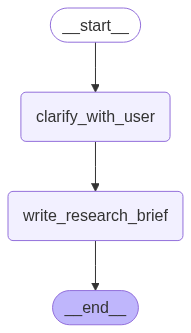

In [7]:
clarify_graph = StateGraph(
    AgentState,
    input_schema=AgentInputState,
    context_schema=Configuration,
)

clarify_graph.add_node("clarify_with_user", clarify_with_user)
clarify_graph.add_node("write_research_brief", write_research_brief)

clarify_graph.add_edge(START, "clarify_with_user")
clarify_graph.add_edge("clarify_with_user", "write_research_brief")
clarify_graph.add_edge("write_research_brief", END)

clarify_workflow = clarify_graph.compile(name="Clarify with User")
clarify_workflow

In [11]:
PROJECT_IDEA = "create plan to develop agentic AI note taking app using langgraph for my personal use (personal project for fun and learning) and i also want to show off my skills to my potential interviewer to get hired. it should do following "


In [12]:
"1. take pictures of hand-written notes "
"2. it will automatically format the hand-written notes (it might contains equations and block diagrams) "
"3. find proper section (if section found then create sub page or create a new page) in my notion "
"4. add this notes with proper format"
"5. i want to use LangGraph's pre-build UI for interaction from PC"
"6. for MVP (which can convert image to text and format it properly) in 2 weeks"
"7. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)"


'7. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)'

In [20]:
thread_config = {"configurable": Configuration().model_dump()}

# response = await clarify_workflow.ainvoke(
#     {"messages": [HumanMessage(content="hello")], "config": thread_config}
# )
# response
response = await clarify_workflow.ainvoke(
    {"messages": [HumanMessage(content=PROJECT_IDEA)], "config": thread_config},
)


In [21]:
response


{'messages': [HumanMessage(content='create plan to develop agentic AI note taking app using langgraph for my personal use (personal project for fun and learning) and i also want to show off my skills to my potential interviewer to get hired. it should do following ', additional_kwargs={}, response_metadata={}, id='9eb4048b-0965-451b-9084-cc2384724640'),
  AIMessage(content='Could you please specify which features you expect in your agentic AI note-taking app using LangGraph? For example, how should it manage notes, interact with users, or integrate with other services?', additional_kwargs={}, response_metadata={}, id='32e4f432-3da1-443e-9c5c-c180de8a4f76')],
 'supervisor_message': [],
 'research_brief': 'For my personal project aimed at developing an agentic AI note-taking application using LangGraph for personal use and potential professional showcase, I aim to define a detailed plan that includes specific features such as intelligent note management, user interaction, and service int

In [ ]:
thread_config = {"configurable": Configuration().model_dump()}

# response = await clarify_workflow.ainvoke(
#     {"messages": [HumanMessage(content="hello")], "config": thread_config}
# )
# response
async for msg, metadata in clarify_workflow.astream(
    {"messages": [HumanMessage(content=PROJECT_IDEA)], "config": thread_config},
    stream_mode="messages",
):
    print(msg)
    # obj = ClarifyWithUser.model_validate(msg.content)
    # print(obj.question)
    # print(msg.content, end="", flush=True)
    # print(metadata["langgraph_node"], end="", flush=True)


TypeError: No synchronous function provided to "clarify_with_user".
Either initialize with a synchronous function or invoke via the async API (ainvoke, astream, etc.)